# Training a Vector Autoregressive Model (VAR)

This notebook will outline the process of fitting a VAR model.

### Further Resources

 * <a href="https://faculty.washington.edu/ezivot/econ584/notes/varModels.pdf">More info on VAR</a>
 * <a href="https://docs.w3cub.com/statsmodels/examples/notebooks/generated/statespace_varmax/">Fitting VARMAX models in Python with statsmodels</a>

In [29]:
import os 
#if you want to know current working dir
print(os.getcwd())
print(os.listdir("."))
from platform import python_version

print(python_version())

/home/admin/Desktop/projects/mlnotebooks
['.git', '.ipynb_checkpoints', 'fileloader.py', 'RFSpectrumWeatherForecast.py', 'RFSpectrumWeatherTraining.py', '__pycache__', 'generate_fake_data.ipynb', '.gitignore~', '2019-11-04_fake_Ark_data.csv', 'fitting_var_ark_legacy.ipynb', '.gitignore', 'fitting_var_ark.ipynb', '2019-11-05_ML1a_X.npy', '2019-11-05_ML1a_Y.npy', '2019-11-05_ML1b_X.npy', '2019-11-05_ML1b_Y.npy', 'time_series_neural_nets.ipynb', '{}_ML1a_X.npy', '{}_ML1a_Y.npy', '{}_ML1b_X.npy', '{}_ML1b_Y.npy', 'ML1b_X.npy', 'ML1b_Y.npy', 'requirements.txt', 'README.md', 'fake_Ark_data.csv', 'ML1a_X.npy', 'ML1a_Y.npy', 'ML2a_X.npy', 'ML2a_Y.npy', 'ML2b_X.npy', 'ML2b_Y.npy', 'ML3_X.npy', 'ML3_Y.npy', 'ML4_X.npy', 'ML4_Y.npy']
3.6.8


In [30]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.statespace.varmax import VARMAX
from statsmodels.graphics.tsaplots import plot_acf

# Load Fake Data
The fake data has dimensions of (time step, feature). The features are either the power spectral density per channel *or* the power spectral density and duty cycle of a single channel. ie the data must be two dimensional.

# Process Data
Here we can aggregate by the time dimension. Use this to create different time steps. Note that the cells below aggregate with summation. This may not be ideal for all situations and should be changed accordingly.

### NOTE
Areas missing. Data needs to be generated.

In [47]:
time_column = 'time'
time_interval_length = 3 # quantum of time

In [48]:
# Sort by time
df.sort_values(by = time_column, inplace = True)

first_measurement_time = np.min(df[time_column].values)
last_measurement_time = np.max(df[time_column].values)

df_binned = df.groupby(pd.cut(df[time_column], 
                              np.arange(first_measurement_time, 
                                        last_measurement_time, 
                                        time_interval_length)
                             )
                      ).sum()

df_binned.reset_index(inplace = True, drop = True)

print("Shape of binned data: {}".format(df_binned.shape))

# Remember to remove time columns!
df_binned.drop([time_column], axis=1, inplace=True)

df = df_binned

Shape of binned data: (3332, 31)


In [49]:
# Train/test split, 0.7 is a typical value for choosing
# the size of the training set, but the optimal approach
# is to use a test set of a size that will allow for 
# the required precision in performance metrics. ie
# choose how tight you would like the confidence interval
# to be and work backwards to a test set size.
train_fraction = 0.7
train_examples = int(len(df)*train_fraction)

train_df = df.iloc[0:train_examples]
test_df = df.iloc[train_examples:]

print("Train data shape: {}".format(train_df.shape))
print("Test data shape: {}".format(test_df.shape))

Train data shape: (2332, 30)
Test data shape: (1000, 30)


# Data Exploration and Visualisation

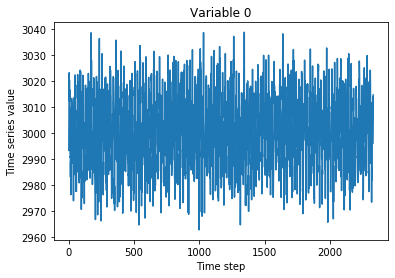

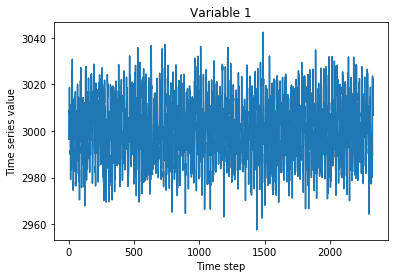

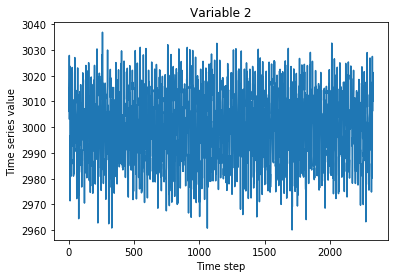

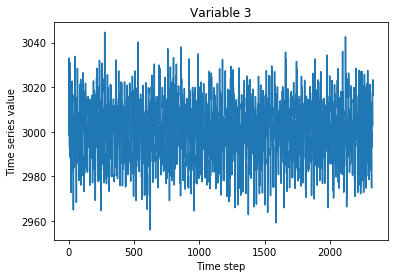

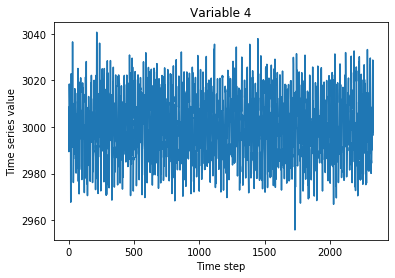

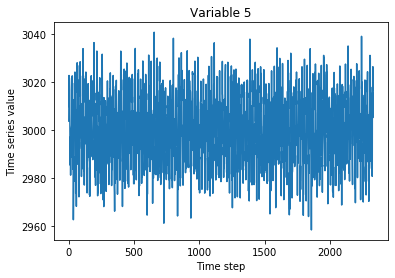

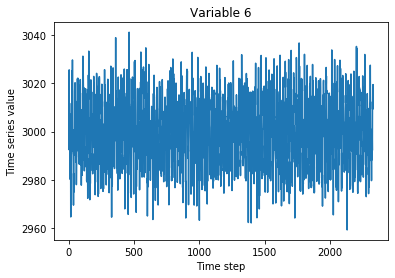

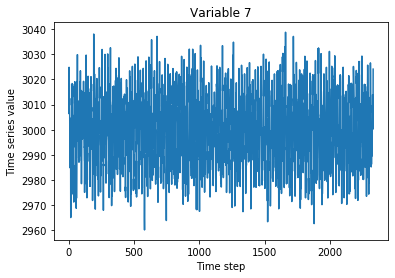

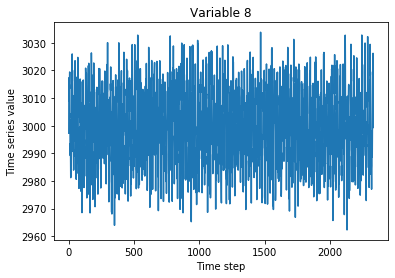

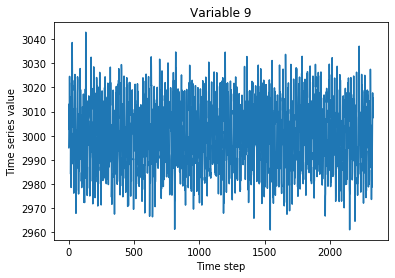

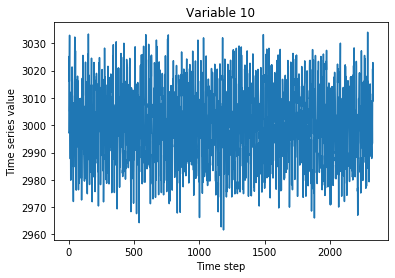

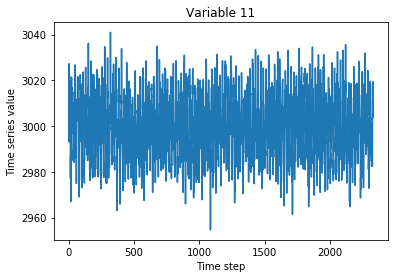

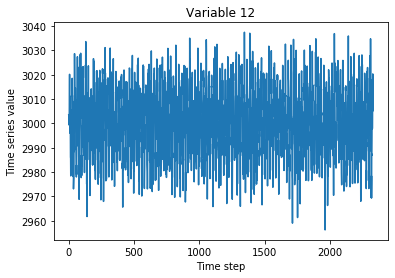

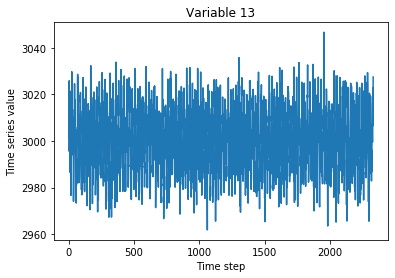

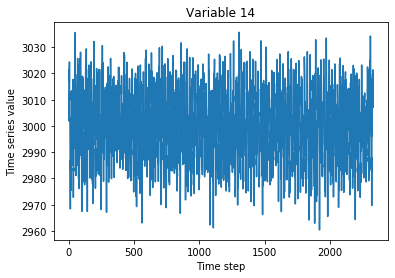

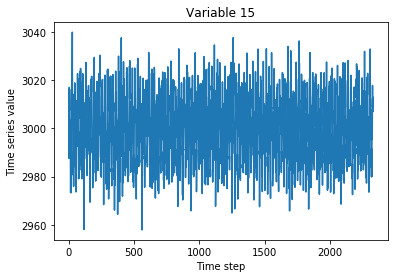

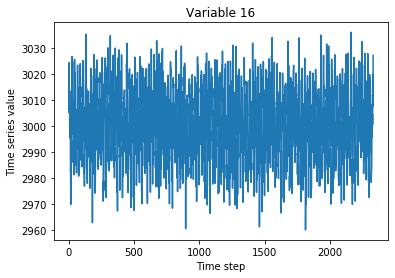

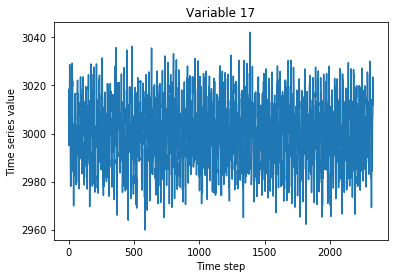

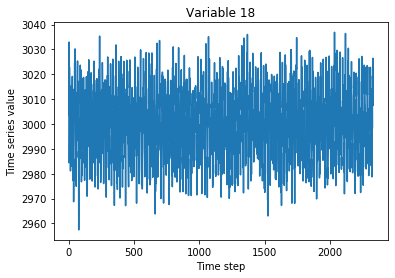

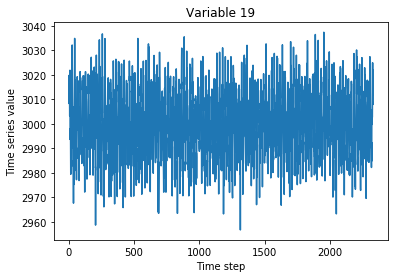

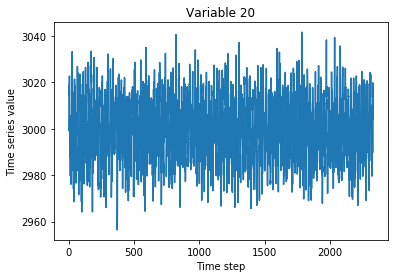

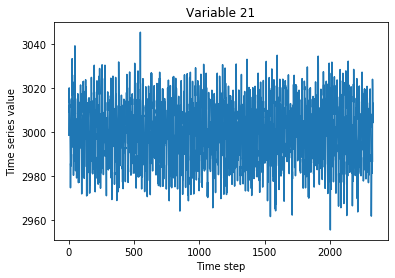

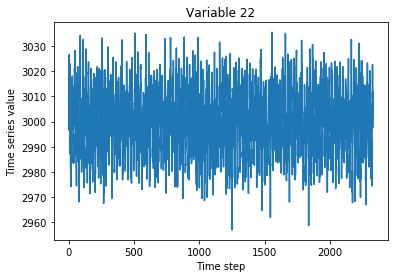

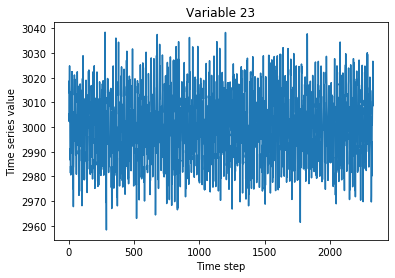

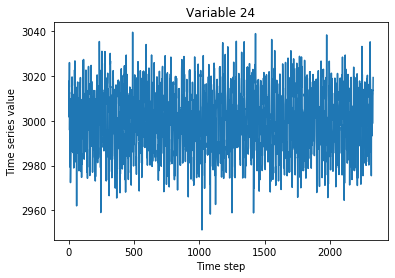

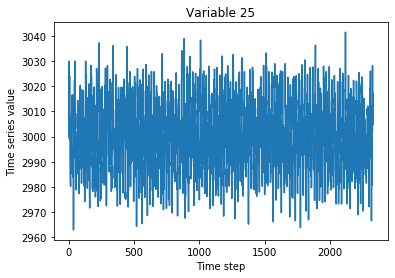

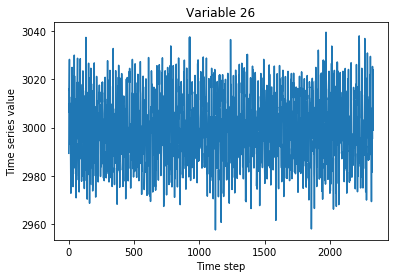

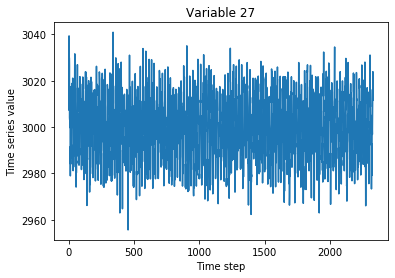

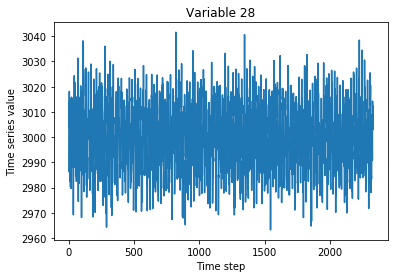

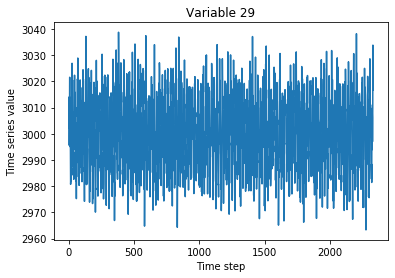

In [50]:
num_vars = int(np.ceil(train_df.shape[1]))
col_names = train_df.columns

for col_num in range(num_vars):
    plt.plot(train_df.iloc[:,col_num])
    plt.title("Variable {}".format(col_names[col_num]))
    plt.xlabel("Time step")
    plt.ylabel("Time series value")
    plt.show()

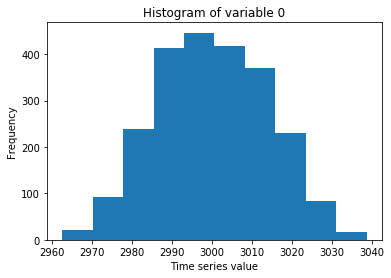

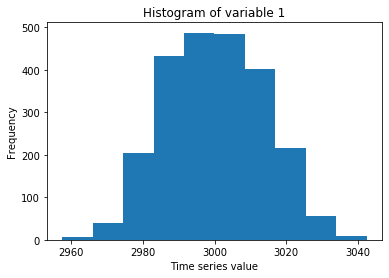

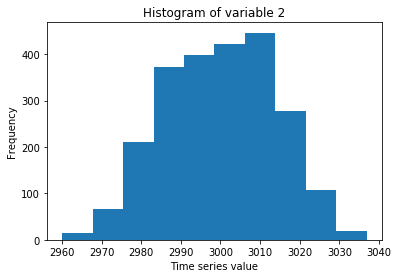

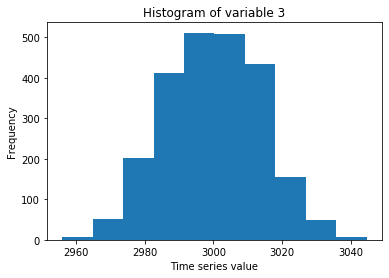

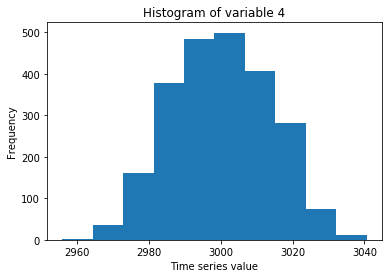

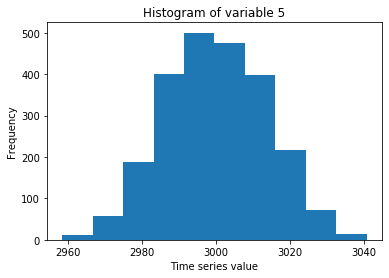

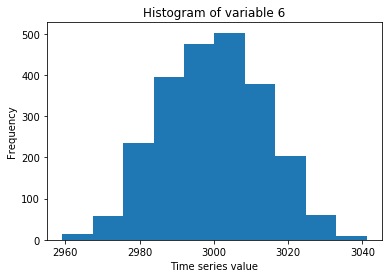

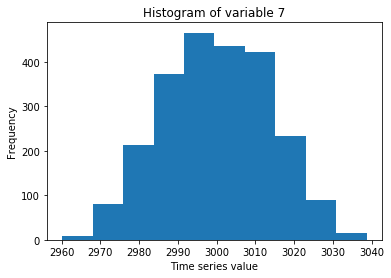

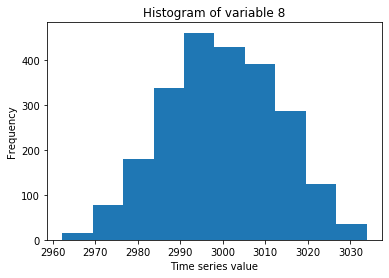

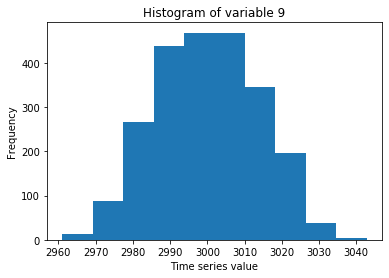

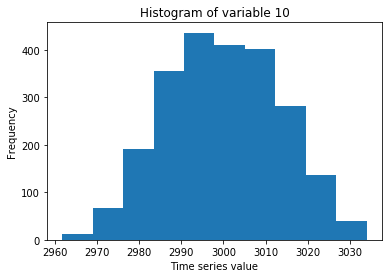

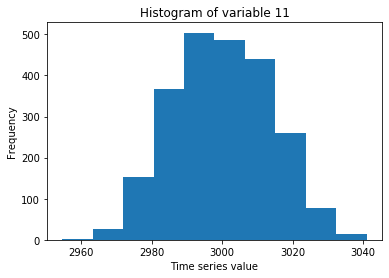

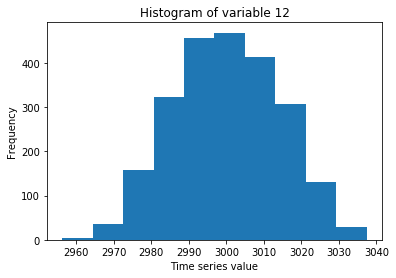

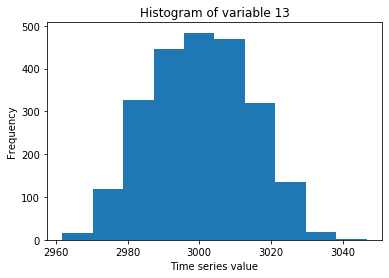

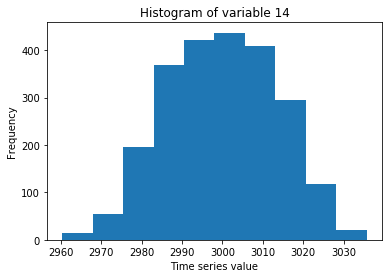

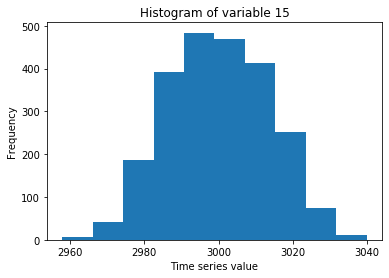

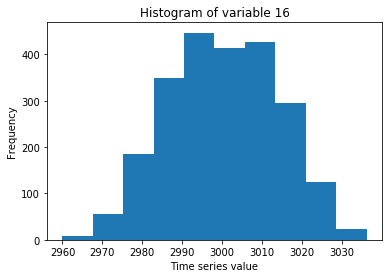

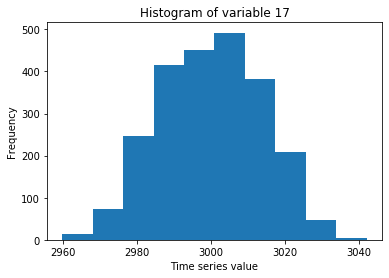

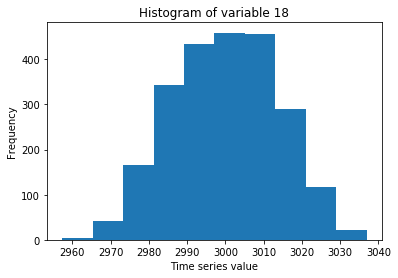

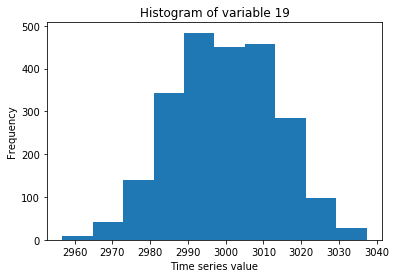

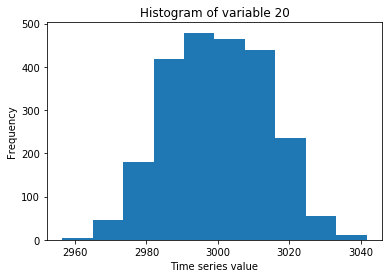

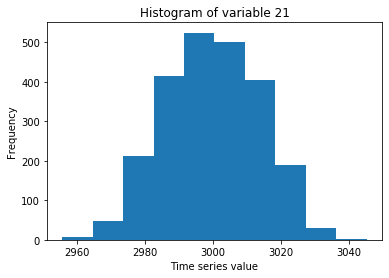

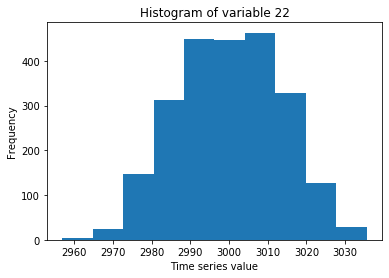

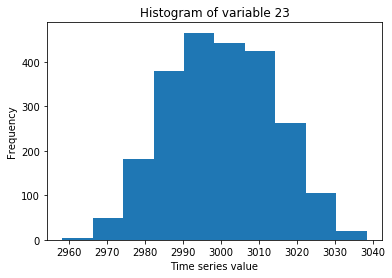

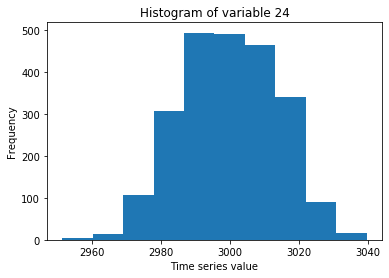

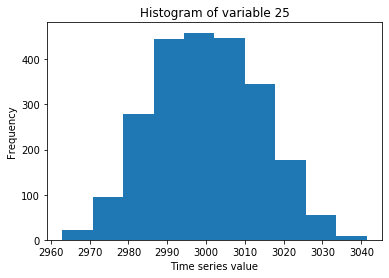

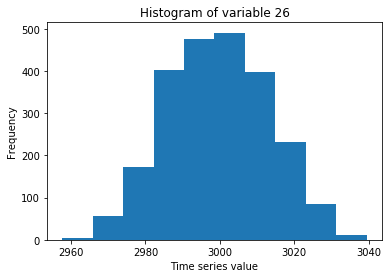

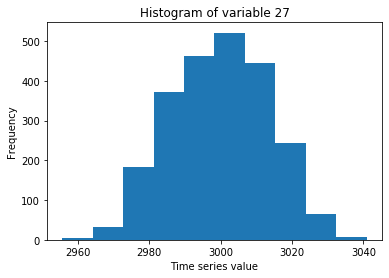

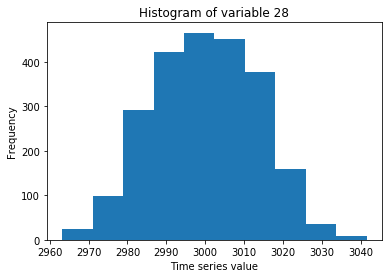

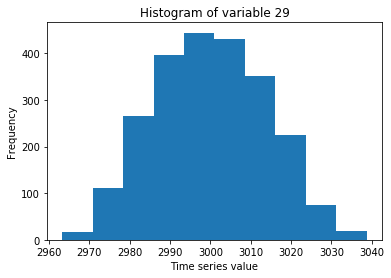

In [51]:
for col_num in range(num_vars):
    
    plt.hist(train_df.iloc[:,col_num])
    plt.title("Histogram of variable {}".format(col_names[col_num]))
    plt.xlabel("Time series value")
    plt.ylabel("Frequency")
    plt.show()

# Additional Feature Selection/Preprocessing

For now this just consists of dropping zero-variance and categorical columns.

In [52]:
for k in train_df.keys():
    # check for zero variance
    if np.var(train_df[k]) == 0:
        print('* Dropping zero variance col', k)
        train_df = train_df.drop(k, axis=1)
        test_df = test_df.drop(k, axis=1)
        continue

# Fitting a Vector Autoregressive Model

### Test for stationary series

Test if features are stationary, as this is a requirement of VAR. Any non-stationary features are dropped. Ideally the time series should be processed beforehand to be as close to stationary as possible.

In [53]:
def is_stationary(df, k, doprint=True):
    # Take 2 sequences of max_size
    # if these are stationary then assume whole thing is stationary
    
    """
    Overview
    --------
    Check if kth column of df is stationary.
    
    
    Inputs
    ------
    df (Pandas dataframe): Pandas dataframe with shape (time step, variable).
    k (int): column number to test.
    doprint (bool): Boolean indicating whether test results
        are printed to screen.
        
        
    Returns
    -------
    Tuple containing (stationary or not, string, stat string).
    """
    
    assert k <= df.shape[1], "k out of column range."

    seq_cnt = 2
    seq_len = len(df[k])
    max_size = 100000
    ratio = (1.0 * seq_len) / max_size
    if ratio > 1.0:
        if ratio > seq_cnt:
            iters = seq_cnt
        else:
            iters = int(ratio)
    else:
        iters = 1
        
    b = True
    st_idx = 0
    end_idx = min(max_size, seq_len)
    i = 0
    while (i < iters and b):
           
        print(f"testing stationarity from: {st_idx} to: {end_idx} for column: {k}", flush=True)
        ad = adfuller(df[k][st_idx:end_idx])
        stat = ad[0]           # statistic
        p = ad[1]              # p-value
        sig = ad[4]['5%']      # 5% confidence
        b = b and stat < sig         # if this is true it is stationary
        
        st_idx += int(seq_len / iters)
        end_idx = min(int(st_idx + max_size), seq_len)
        i += 1
        
    sry = 'stationary' if b else 'non-stationary'
    stat_tup = (b, sry, stat, p, sig)
    if doprint:
        print('-- Dickey-Fuller {} ({})'.format(k, sry), flush=True)
        print('\tstat={} p={} 5%={}'.format(stat, p, sig, sep='\t'), flush=True)
    return b    # a triple (stationary or not, string, stat string)

In [54]:
for k in train_df.keys():
    # check for non-stationary
    if not is_stationary(train_df, k):
        print('* Dropping non-stationary col', k)
        train_df = train_df.drop(k, axis=1)
        test_df = test_df.drop(k, axis=1)
        continue

testing stationarity from: 0 to: 2332 for column: 0
-- Dickey-Fuller 0 (stationary)
	stat=-8.184120259981386 p=7.98447896438771e-13 5%=-2.8627947264262703
testing stationarity from: 0 to: 2332 for column: 1
-- Dickey-Fuller 1 (stationary)
	stat=-7.553720525093692 p=3.139450967404384e-11 5%=-2.8627952713612634
testing stationarity from: 0 to: 2332 for column: 2
-- Dickey-Fuller 2 (stationary)
	stat=-8.149590351025985 p=9.777380884476407e-13 5%=-2.8627952713612634
testing stationarity from: 0 to: 2332 for column: 3
-- Dickey-Fuller 3 (stationary)
	stat=-8.631567086750746 p=5.736837196200716e-14 5%=-2.8627947264262703
testing stationarity from: 0 to: 2332 for column: 4
-- Dickey-Fuller 4 (stationary)
	stat=-7.609338881619587 p=2.2770906313987038e-11 5%=-2.862793094456392
testing stationarity from: 0 to: 2332 for column: 5
-- Dickey-Fuller 5 (stationary)
	stat=-8.937028839302425 p=9.473289782892862e-15 5%=-2.8627925514094192
testing stationarity from: 0 to: 2332 for column: 6
-- Dickey-Ful

### Investigate Autocorrelation
These should not be flat.

  plot: 1 key: 0 from range ( 0 , 2332 )
  plot: 2 key: 1 from range ( 0 , 2332 )
  plot: 3 key: 2 from range ( 0 , 2332 )
  plot: 4 key: 3 from range ( 0 , 2332 )
  plot: 5 key: 4 from range ( 0 , 2332 )
  plot: 6 key: 5 from range ( 0 , 2332 )
  plot: 7 key: 6 from range ( 0 , 2332 )
  plot: 8 key: 7 from range ( 0 , 2332 )
  plot: 9 key: 8 from range ( 0 , 2332 )
  plot: 10 key: 9 from range ( 0 , 2332 )
  plot: 11 key: 10 from range ( 0 , 2332 )
  plot: 12 key: 11 from range ( 0 , 2332 )
  plot: 13 key: 12 from range ( 0 , 2332 )
  plot: 14 key: 13 from range ( 0 , 2332 )
  plot: 15 key: 14 from range ( 0 , 2332 )
  plot: 16 key: 15 from range ( 0 , 2332 )
  plot: 17 key: 16 from range ( 0 , 2332 )
  plot: 18 key: 17 from range ( 0 , 2332 )
  plot: 19 key: 18 from range ( 0 , 2332 )
  plot: 20 key: 19 from range ( 0 , 2332 )
  plot: 21 key: 20 from range ( 0 , 2332 )
  plot: 22 key: 21 from range ( 0 , 2332 )
  plot: 23 key: 22 from range ( 0 , 2332 )
  plot: 24 key: 23 from range 

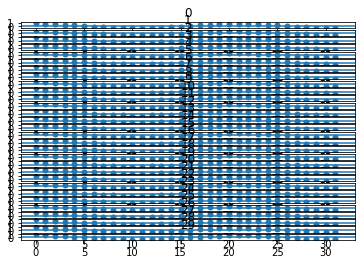

In [55]:
# do autocorrelation function plots
r_s = r_e = None
i = 1
pltn = len(train_df.keys())
for k in train_df.keys():
    # Choose a middle section of 200K values to auto-corrolate
    sect_size = 200000
    if train_df.shape[0] < sect_size:
        sect_size = train_df.shape[0]

    if r_s is None:
        r_s = int((len(train_df[k]) - sect_size) / 2)
        r_e = r_s + sect_size

    # make acf plots
    print('  plot:', i, 'key:', k, 'from range (', r_s, ',', r_e, ')', flush=True)
    if i <= pltn:
        ax = plt.subplot(pltn, 1, i)
        plot_acf(train_df[k][r_s:r_e], lags=31, ax=ax)
        plt.title(k)
    else:
        print('ERROR: Trying to plot out side of range for plot:', i, 'key:', k, flush=True)

    i = i + 1
    
#plt.figure(figsize=(16, 12))
plt.show()

Correlating samples 0 to 2332.


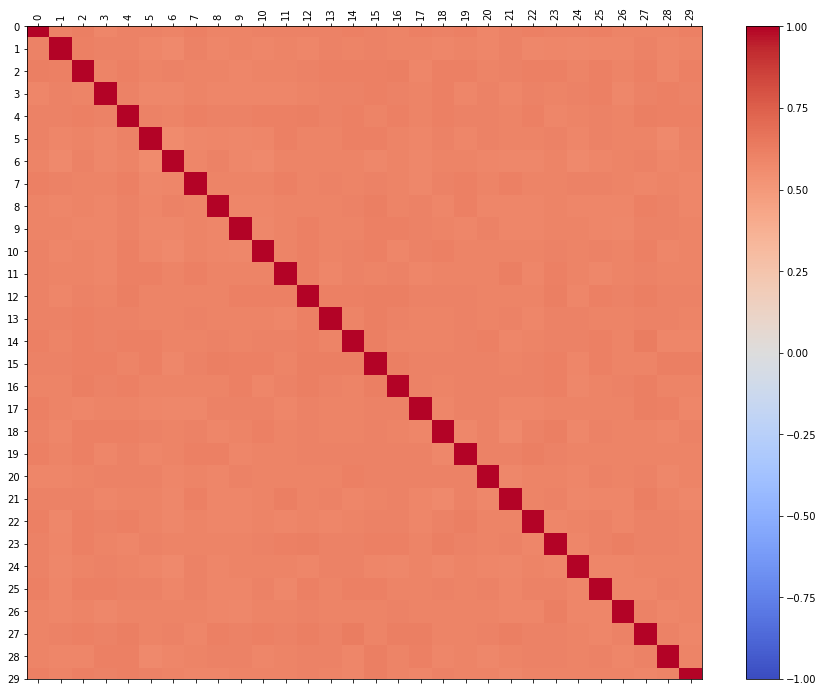

In [56]:
# correlation plot
# Choose the middle section of values to auto-correlate
sect_size = 1000000
if train_df.shape[0] < sect_size:
    sect_size = train_df.shape[0]

r_s = int((train_df.shape[0] - sect_size) / 2)
r_e = r_s + sect_size

print(f"Correlating samples {r_s} to {r_e}.")
corr = train_df[r_s:r_e].corr()
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.columns),1)
ax.set_xticks(ticks)
plt.xticks(rotation=90)
ax.set_yticks(ticks)
ax.set_xticklabels(df.columns)
ax.set_yticklabels(df.columns)
plt.show()


# Train VAR Model
If you receive the following error

```n-th leading minor of the array is not positive definite```

then you do not have enough data to effectively fit a model of the given complexity. Try dropping some features or using a lower value for ```maxlags```.

In [57]:
# make a model
maxlags = 1 # number of time lags to autoregress on
information_criterion = 'aic'
max_fit_samples = 1000
numrecs = train_df.shape[0]

use_max_fit_samples = numrecs

if numrecs > max_fit_samples:
    use_max_fit_samples = max_fit_samples

print("Make a VAR model with maxlags = " + str(maxlags) + " and IC= " 
      + information_criterion + " and samples constrained to = " 
      + str(use_max_fit_samples) + " :")

model = VAR(train_df.values[0:use_max_fit_samples])

model_fit = model.fit(maxlags=maxlags, ic=information_criterion)
print(model_fit.summary())

Make a VAR model with maxlags = 1 and IC= aic and samples constrained to = 1000 :
  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 07, Nov, 2019
Time:                     08:54:42
--------------------------------------------------------------------
No. of Equations:         30.0000    BIC:                    136.618
Nobs:                     999.000    HQIC:                   133.787
Log likelihood:          -107555.    FPE:                2.23363e+57
AIC:                      132.050    Det(Omega_mle):     8.93016e+56
--------------------------------------------------------------------
Results for equation y1
            coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------
const        140.619942        86.250503            1.630           0.103
L1.y1         -0.017844         0.034626           -0.515           0.606
L1.y2    

In [71]:
model_fit.llf

-107554.75319133564

# Evaluate Model
If this returns ```IndexError: index 0 is out of bounds for axis 0 with size 0```, then your VAR model likely consists only of constants. This occurs when there is no pattern in your data to model. 

In [58]:
horizon = 10
forecast_values = model_fit.forecast(train_df.values[0:use_max_fit_samples], 10*horizon)

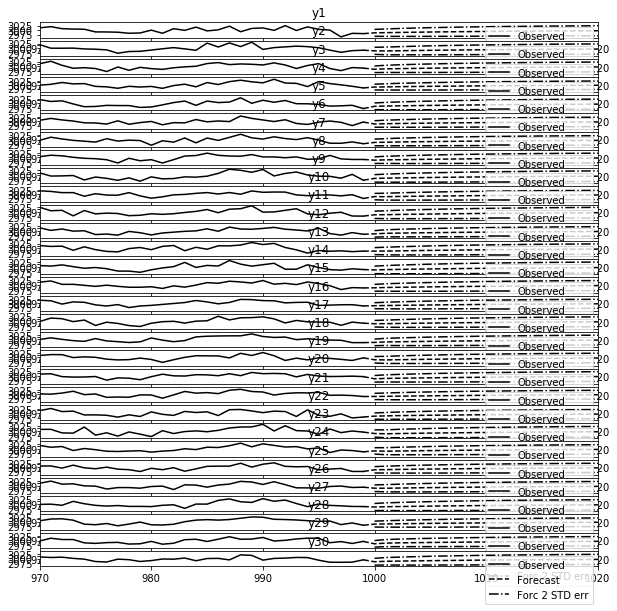

In [59]:
forecast_fig = model_fit.plot_forecast(horizon*10)
axes = forecast_fig.get_axes()
#Restrict axis to show interesting forecast bit
axmin = use_max_fit_samples - (horizon * 3)
axmax = use_max_fit_samples + (horizon * 2)

for ax in axes:
    ax.set_xlim(axmin, axmax)

We now plot model predictions against test data. First we plot model predictions over the test set, where predictions for one point in time are used in predictions of future points in time. In other words, we are predicting k-steps ahead with k equal to the number of examples in the test set. Next, we do k-steps ahead prediction with k equal to a value less than the number of examples in the test set, meaning that we will have access to values in the test set, but only after they have occured.

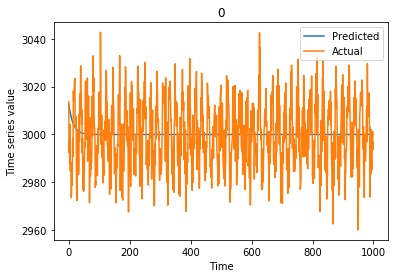

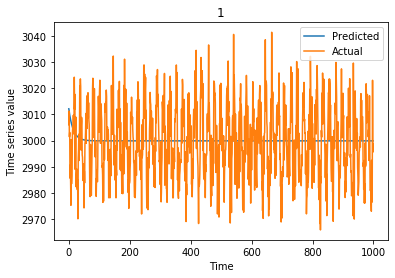

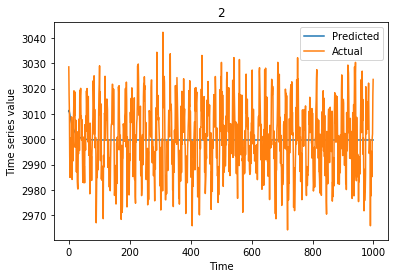

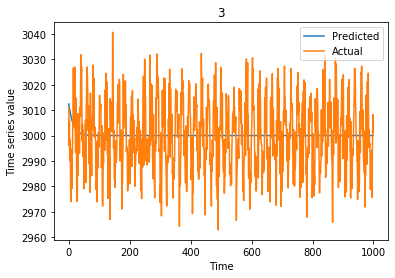

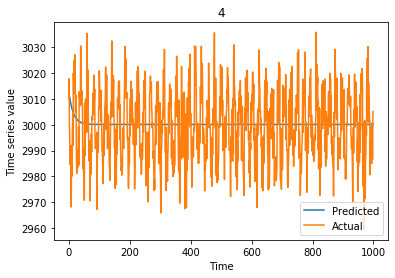

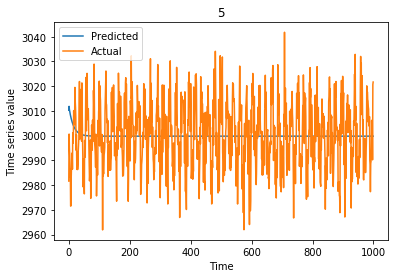

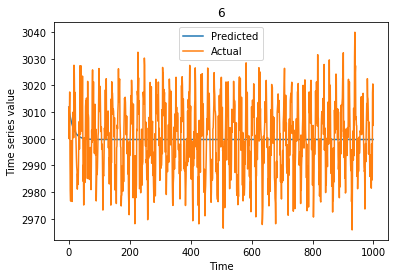

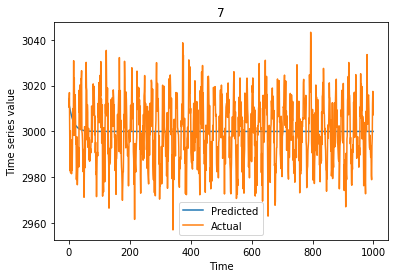

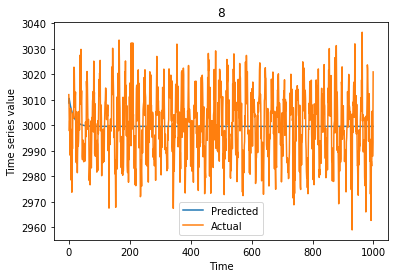

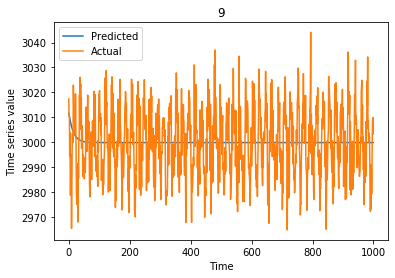

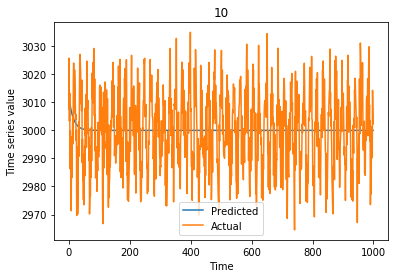

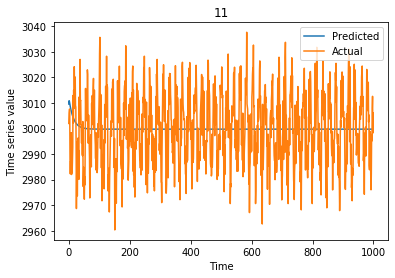

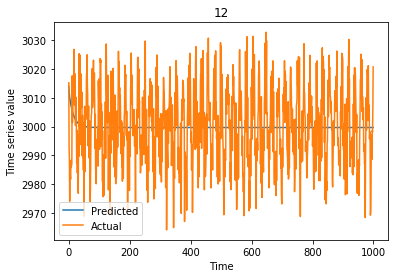

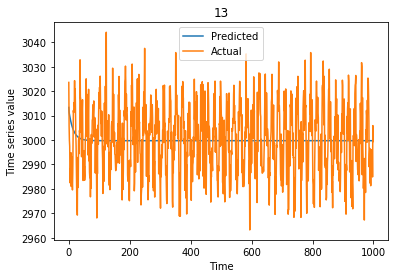

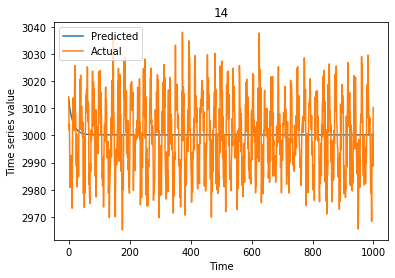

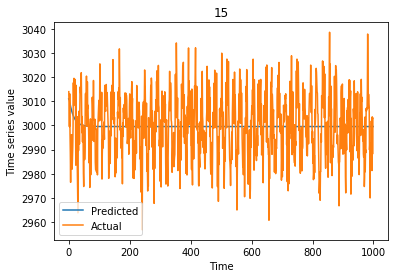

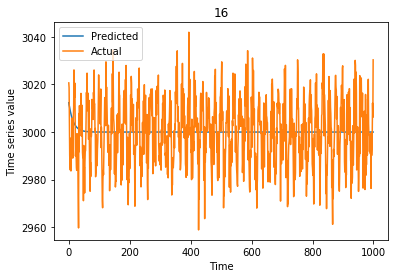

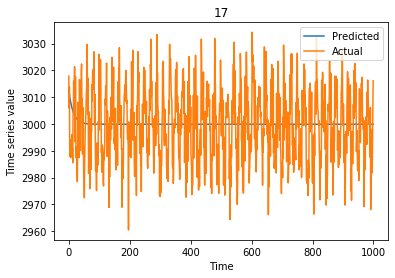

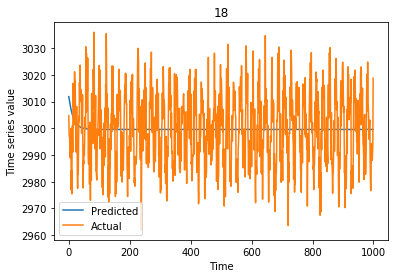

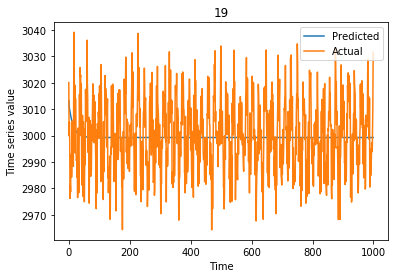

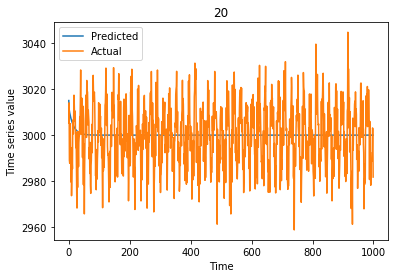

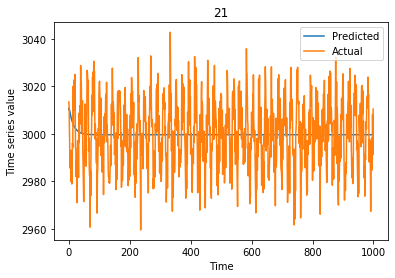

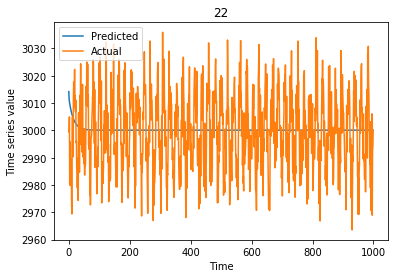

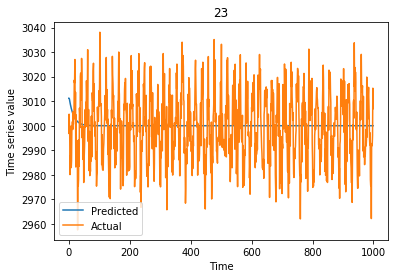

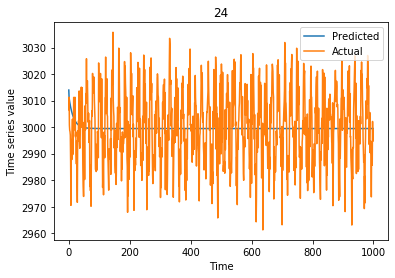

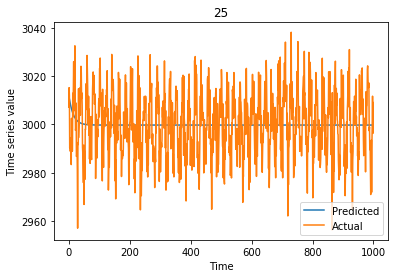

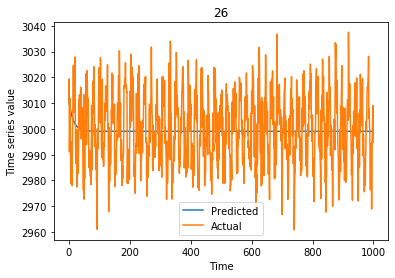

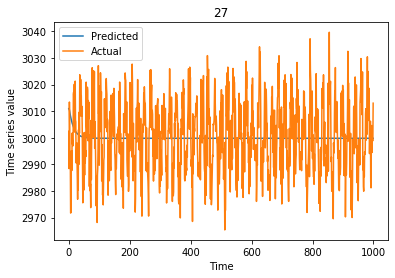

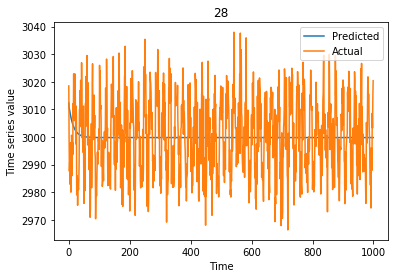

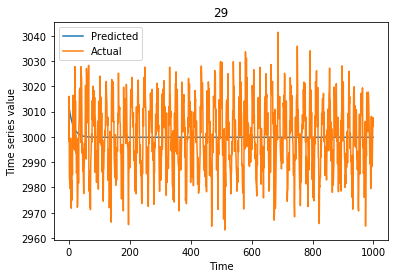

In [60]:
forecast_length = test_df.shape[0]

predictions = model_fit.forecast(train_df.values, forecast_length)

var_names = train_df.columns

for i in range(np.shape(train_df)[1]):
    
    plt.plot(predictions[:,i], label = "Predicted")
    plt.plot(test_df.values[:,i], label = "Actual")
    plt.xlabel("Time")
    plt.ylabel("Time series value")
    plt.title(var_names[i])
    plt.legend()
    plt.show()

In [61]:
def k_steps_forecast(trained_model, X_train, X_test, k=1):
    
        """
        Overview
        --------
        Does a k-step ahead forecast.
    
        e.g. for a 10 step ahead forecast, this function will return 
        the predicted forecast value 10 time steps ahead. In other
        words, each predicted value is based on using informaton at
        least k steps prior to the event.
    
        Inputs
        ------
        X_train (numpy.ndarray): Data VAR model was trained on.
        X_test (numpy.ndarray): Data VAR model is trying to predict.
        k (int): steps ahead to forecast. Must be greater than 0.
    
        Returns
        -------
        var_forecasts_list (list): List of NumPy arrays containing
            forecast arrays of shape 
            (<time step>, <variable>)
        """
    
        assert k > 0
        assert self.trained_model != None
    
        num_forecasts = np.shape(X_test)[0]
    
        X_train_len = len(X_train)
        X_combined = np.concatenate([X_train, X_test])
    
        forecasts = []
    
        # Make forecasts
        for forecast_idx in range(num_forecasts):
    
            nth_predictions = trained_model.forecast(X_combined[:X_train_len+forecast_idx], k)
            forecasts.append(np.array(nth_predictions)[k-1:])
        
        forecasts = np.reshape(forecasts, (len(X_train), -1))

        return forecasts

In [62]:
forecast_length = 200

var_forecasts = k_steps_forecast(model_fit, train_df.values, test_df.values)

Now we get performance metrics and visualise the results of k-step-ahead forecasts.

Change ```var_num``` to get the visualisations and metrics of the nth variable.

NOTE: The following cell may not work as k_step_ahead_forecast has been updated.

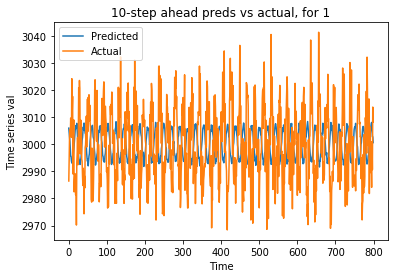

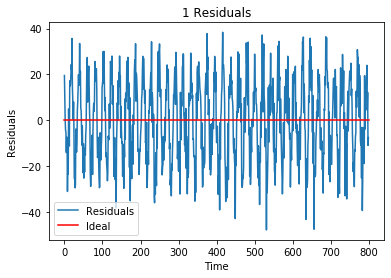

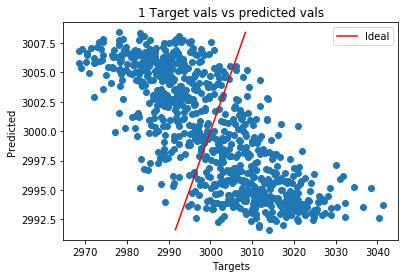

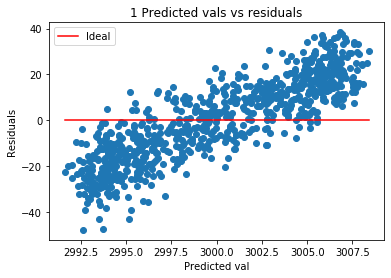

r_squared: -12.697001007720242, rmse: 17.79884205022428, mae: 15.164164461401793, me: 47.88074932411382
Metrics scaled by standard deviation:
rmse: 1.2846967312526887, mae: 1.0945292093030057


In [65]:
pred_len = np.shape(var_forecasts)[1]

k_val = 10
var_num = 1

predicted_vals = var_forecasts[var_num][:,k_val]
target_vals = test_df.values[(k_val):(k_val+pred_len)][:,var_num]
residuals = predicted_vals-target_vals

column_name = df.columns[var_num]

plt.plot(predicted_vals, label = "Predicted")
plt.plot(target_vals, label = "Actual")
plt.title("{}-step ahead preds vs actual, for {}".format(k_val, column_name))
plt.xlabel("Time")
plt.ylabel("Time series val")
plt.legend()
plt.show()

plt.plot(residuals, label = "Residuals")
ideal_line_min = [0,len(residuals)]
ideal_line_max = [0,0]
plt.plot(ideal_line_min, ideal_line_max, c = 'r', label = "Ideal")
plt.title("{} Residuals".format(column_name))
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.legend()
plt.show()

plt.scatter(target_vals, predicted_vals)
ideal_line_min = [np.min(predicted_vals,), np.max(predicted_vals,)]
ideal_line_max = [np.min(predicted_vals,), np.max(predicted_vals,)]
plt.plot(ideal_line_min, ideal_line_max, c = 'r', label = "Ideal")
plt.title("{} Target vals vs predicted vals".format(column_name))
plt.xlabel("Targets")
plt.ylabel("Predicted")
plt.legend()
plt.show()

plt.scatter(predicted_vals, residuals)
ideal_line_min = [np.min(predicted_vals),np.max(predicted_vals)]
ideal_line_max = [0,0]
plt.plot(ideal_line_min, ideal_line_max, c = 'r', label = "Ideal")
plt.title("{} Predicted vals vs residuals".format(column_name))
plt.xlabel("Predicted val")
plt.ylabel("Residuals")
plt.legend()
plt.show()

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, max_error

# Other performance metrics
r_squared = r2_score(predicted_vals, target_vals)
rmse = np.sqrt(mean_squared_error(predicted_vals, target_vals))
mae = mean_absolute_error(predicted_vals, target_vals)
me = max_error(predicted_vals, target_vals)

std = np.std(target_vals)
print("r_squared: {}, rmse: {}, mae: {}, me: {}".format(r_squared, rmse, mae, me))
print("Metrics scaled by standard deviation:")
print("rmse: {}, mae: {}".format(rmse/std, mae/std))

Plotting the autocorrelation function of the residuals will tell us if we have successfully captured all of the structure within the data. The presence of autocorrelation in the residuals would suggest that we have not.

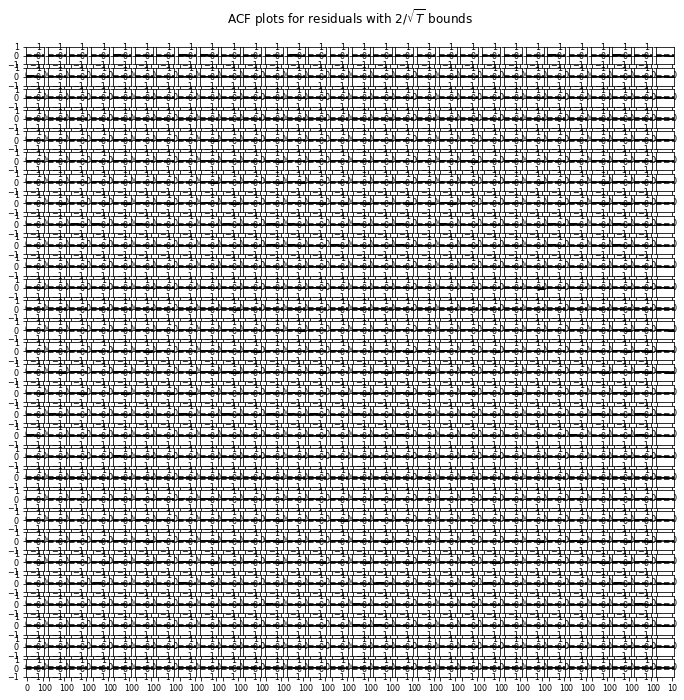

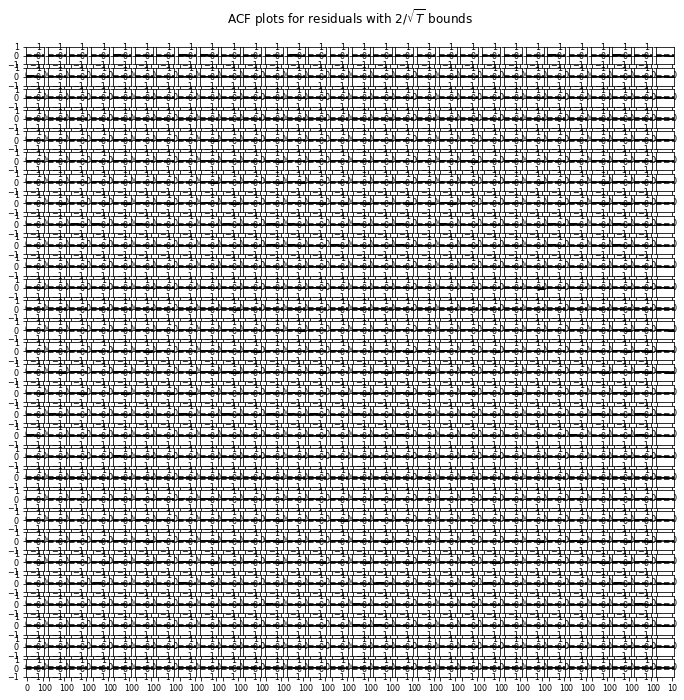

In [64]:
model_fit.plot_acorr()

# Conclusion
